In [21]:
'''
TO DO LIST:
1. Add function to convert between Hall mobility, Hall carrier concentration, and Hall factor
2. Mulitple Compounds Plot 
'''
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
import sys
import os

In [22]:
kB = 1.38e-23 # V / K
h = 6.626e-34 # J * s
hbar = 1.054e-34 # J * s

e = 1.602e-19 # C
me = 9.11e-31 # kg
Na = 6.02e23 # /mol

In [23]:
def read_STD2(fpath : str):
    df = pd.read_csv(fpath)
    return df


In [24]:
def reduced_df_by_sample(full_df, composition: str):
    comp_df = full_df.loc[full_df['composition'] == composition]
    return comp_df


In [25]:
def add_weighted_mobility(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    rat = kB / e
    aS = np.abs(S)
    muW = 331 * (1e-5 / rho) * (T / 300)**(-3 / 2) * (np.exp(aS/rat - 2)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + 3 * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Weighted mobility'] = muW
    return comp_df


In [26]:
def add_effective_mass(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    nH = comp_df['Carrier concentration']
    rat = kB / e
    aS = np.abs(S)
    muS = (h**2/(2*kB*T))*(3*nH/16*pi**.5)**(2/3)* ((np.exp(aS/rat - 2)-0.17)**(2/3)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + (3/pi**2)*(2/pi**0.5)**(2/3) * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Seebeck Effective Mass'] = muS/me
    return comp_df

In [27]:
def convert_hall_data(comp_df):
    # If carrier concentration doesn't exist and mobility exists, calculate carrier concentration
    if ( np.isnan(comp_df['Carrier concentration']).any() ) and ( not np.isnan(comp_df['Carrier mobility']).any() ):
        Rh = comp_df['Carrier mobility'].to_numpy() * comp_df['Electrical resistivity'].to_numpy()
        nh = (Rh * e) ** -1
        comp_df['Carrier concentration'] = nh
    
    # If mobility doesn't exist and carrier concentration exists, calculate mobility
    elif ( not np.isnan(comp_df['Carrier concentration']).any() ) and ( np.isnan(comp_df['Carrier mobility']).any() ):
        comp_df['Carrier mobility'] = (comp_df['Carrier concentration'].to_numpy() * comp_df['Electrical resistivity'].to_numpy() * e )**(-1)
    
    return comp_df

In [28]:
def split_sampleid(comp_df):
    sid = comp_df['sampleid'].to_numpy()
    unique_sampleid, sampleid_counts = np.unique(sid, return_counts=True)
    data = {}
    for sampleid in unique_sampleid:
        data[str(int(sampleid))] = comp_df.loc[comp_df['sampleid'] == sampleid]
    #print(data)
    return data
'''
new_data = split_sampleid(comp_df)
#sample calc
x = new_data['31213']['Temperature'].to_numpy()
#issue: composition is undefined 
print(x)
'''

"\nnew_data = split_sampleid(comp_df)\n#sample calc\nx = new_data['31213']['Temperature'].to_numpy()\n#issue: composition is undefined \nprint(x)\n"

In [29]:
#def samplename(comp_df):
    

In [30]:
def merge_Hallmobility_columns(comp_df):
    for j in comp_df.index:
        if not pd.isna(comp_df['Hall movility'][j]):
            comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
    comp_df.pop('Hall movility')
    return comp_df

In [31]:
def plot_mobility(comp_df):
    #Hall mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Carrier mobility'] * 1e4, color ='red', marker = '>')
    plt.ylabel(r'$\mu_H$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
   
    #line style, while loop, xkcd 
    
    #Weighted mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Weighted mobility'])
    plt.ylabel(r'$\mu_W$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
    
    #Combined Plot
   
    x = comp_df['Temperature']
    y1 = comp_df['Carrier mobility'] * 1e4
    y2 = comp_df['Weighted mobility']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, y1, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax2.plot(x, y2, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax1.set_xlabel('Temperature (Kelvin)')
    ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
    plt.show()
   
    # Seebeck coeff versus cond 
    
    y3 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x2 = comp_df['Electrical conductivity'] #units of Ohm*m
    plt.figure()
    plt.scatter(x2, y3, marker = '*', color = 'indigo')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Electrical Conductivity, \u03C3 (S/m)')
    
    #add pisarenko plot (S versus carrier conc nh)
    
    y4 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x3 = comp_df['Carrier concentration'] #units of Ohm*m
    plt.figure()
    plt.scatter(x3, y4, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉')
    
  

In [32]:
# Pisarenko Plots 
# S dec w/ nH dec cuz metal becomes more metallic 
# carr conc inc w/ T, S dec w/ T 
'''
Added by Ramya: Get list of sample IDs in the new_data
Note: be careful not to name variables "list" because this is
a keyword in Python that shouldn't be overwritten
'''
sid_list = list(new_data.keys()) #To understand this syntax, look up "python dictionaries"
T_list = new_data[sid_list[0]]['Temperature'].to_numpy()
print(T_list)
for i in sid_list: 
    x10 = new_data[i]['Carrier concentration'].to_numpy() #units of V/K
    y10 = new_data[i]['Seebeck coefficient'].to_numpy() * 1e4 #units of Ohm*m
    plt.figure()
    plt.scatter(x10, y10, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, Sample {}'.format(i))
   
# grab interploated data
# Ca Zn Sb compare 
# upwards slope weird - nh inc, S dec ()
# mult S in mV/K, mult by 1e6

NameError: name 'new_data' is not defined

In [33]:
if __name__ == '__main__':
    #Provide path to the .csv file exported from sTarryData2
    full_df = read_STD2('csvfiles/Ca_ptype.csv')
    #Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in full_df.columns:
        full_df['Hall movility'] = np.nan #ad column of empty values
    elif 'Carrier mobility' not in full_df.columns:
        full_df['Carrier mobility'] = np.nan #ad column of empty values
    if 'Carrier concentration' not in full_df.columns:
        full_df['Carrier concentration'] = np.nan #ad column of empty values
    hall_df = full_df.dropna(how = 'all', subset = ['Hall movility','Carrier mobility', 'Carrier concentration'])
    for index,row in hall_df.iterrows:
        if row['Carrier concentration'] < 1e23 and row['Carrier concentration'] > 1e28: #m^-3
            hall_df.drop(index = index, inplace = True)
        if row['Thermal conductivity'] < 0.1 and row['Thermal conductivity'] > 50: #W/m/k
            hall_df.drop(index = index, inplace = True)
        if row['Electrical conductivity'] < 1e3 and row['Electrical conductivity'] > 1e7: #S/m
            hall_df.drop(index = index, inplace = True)
        if row['Seebeck coefficient'] < -1e-3 and row['Seebeck coefficient'] > 1e-3: #V/k
            hall_df.drop(index = index, inplace = True)
    #Drop any rows that don't contain both Seebeck and Conductivity data too
    hall_df = hall_df.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    #Merge Hall mobility data from different columns
    hall_df = merge_Hallmobility_columns(hall_df)
    hall_df = convert_hall_data(hall_df)
    composition = hall_df['composition'][hall_df.index[0]] #Choosing first composition with Hall mobility data
    #Print composition
    print(composition)
    #Get dataframe for just the composition of interest
    comp_df = reduced_df_by_sample(hall_df, composition)
    #Add weighted mobility data
    comp_df = add_weighted_mobility(comp_df)
    #Plots of weighted mobility and Hall mobility
    plot_mobility(comp_df)
    # call effective mass, in terms of mass by e- (divide)
    comp_df = add_effective_mass(comp_df)
    mean = comp_df['Seebeck Effective Mass'].mean()
    #print(mean)
    stdev = comp_df['Seebeck Effective Mass'].std()
    #print(stdev)
    #print(comp_df['Seebeck Effective Mass'])
    new_data = split_sampleid(comp_df)

TypeError: 'method' object is not iterable

In [34]:
#old
# Weighted Mobility Plots (double axes)

#colors 

items = list(new_data.keys())
print(items)
darkcol = ['firebrick', 'orange', 'green', 'navy', 'purple' ]
lightcol = ['red', 'yellow', 'lime', 'cyan', 'magenta']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in items: 
    x = new_data[i]['Temperature'].to_numpy()
    a = new_data[i]['Carrier mobility'].to_numpy() *1e4
    b = new_data[i]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax5.plot(x, b, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)

NameError: name 'new_data' is not defined

In [35]:
# Weighted Mobility Plots (double axes)

#colors 
items = list(new_data.keys())
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in range(len(items)): #range() function is quite useful for looping through the indices of a list
    x = new_data[items[i]]['Temperature'].to_numpy()
    a = new_data[items[i]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i]]['Weighted mobility'].to_numpy() 
    ax4.plot(x, a, darkcol[i % len(darkcol)], marker = 'o', linewidth = 2, markersize = 7.5) #May repeat colors
    ax5.plot(x, b, darkcol[i % len(darkcol)], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
#weighted curved 

NameError: name 'new_data' is not defined

In [36]:
#Revised Pisarenko Plots

#List of temperatures where there is data
T_array = new_data[sid_list[0]]['Temperature'].to_numpy()
index_list = list(new_data[sid_list[0]]['Temperature'].index)
print(T_array)
print(index_list)
'''
Create new dictionary with this structure:

'T' : {'n': [list of carrier concentrations], 'S': [list of Seebeck values]}
'''
prenko_dict = {}

for T in T_array:
    n = [] #carrier concentration
    S = [] #Seebeck coefficient
    Smass = [] #Seebeck effective mass
    for k in new_data.keys(): #This is looping through all the sampleIDs in new_data
        indx_list = new_data[k].index
        indx = indx_list[new_data[k]['Temperature'] == T]
        try:
            n.append(float(new_data[k]['Carrier concentration'][indx]))
            S.append(float(new_data[k]['Seebeck coefficient'][indx]))
            Smass.append(float(new_data[k]['Seebeck Effective Mass'][indx]))
        except:
            continue
    prenko_dict[str(T)] = {}
    prenko_dict[str(T)]['Carrier concentration'] = n
    prenko_dict[str(T)]['Seebeck coefficient'] = S
    prenko_dict[str(T)]['Seebeck Effective Mass'] = Smass

NameError: name 'new_data' is not defined

In [37]:
# Plot Updated Pisarenkos

for k in prenko_dict.keys():
    plt.ylabel(r'Seebeck Coefficient , S ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Pisarenko Plot of ' + composition + ' ' + k + 'C') #update composition; do proper string formatting
    # Plots of Seebeck versus carrier concentration for each temperature
    plt.scatter(prenko_dict[k]['Carrier concentration'], np.array(prenko_dict[k]['Seebeck coefficient']) * 1e6)
    plt.show()
    #Plots of Seebeck eff. mass versus carrier concentration for each temperature
    plt.ylabel(r'Seebeck Effective Mass , $m*_S$ ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Seebeck Effective Mass of ' + composition + k + 'C')     
    plt.scatter(prenko_dict[k]['Carrier concentration'], prenko_dict[k]['Seebeck Effective Mass'])    
    plt.show()


NameError: name 'prenko_dict' is not defined

In [16]:
#z = new_data['31213']['Seebeck Effective Mass'].to_numpy() #units of V/K
#print(z)

# Effective Mass Plots

#colors 
nums = [ 1, 2, 3, 4, 5] 
items = list(new_data.keys())
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in range(len(items)): 
    x = new_data[items[i]]['Temperature'].to_numpy()
    a = new_data[items[i]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i]]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, darkcol[i], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
# weighted curved 

NameError: name 'new_data' is not defined

NameError: name 'arr350x' is not defined

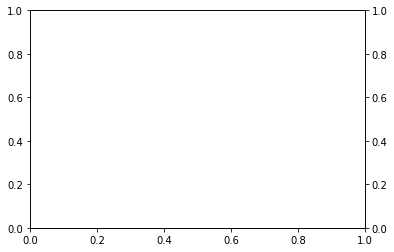

In [17]:
nums = [ 1, 2, 3, 4, 5] 
for i in nums: 
    
    items = ['31213', '31214', '31215', '31216', '31217']
    darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
    lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
    fig, ax4 = plt.subplots()
    ax5 = ax4.twinx()


    x = arr350x[i]
    a = arr350y[i]
    b = arr350ye[i] 

    ax4.plot(x, a, darkcol[i-5], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i-5], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# fitted effective mass plot 350 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()



ax1.plot(arr350x, arr350y, 'blue', marker = 'o', linewidth=0.5, markersize=2)
ax2.plot(arr350x, arr350ye[:len(arr350x)], 'green', marker = 'x', linewidth = 0.3, markersize=2)

ax1.set_xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
       

In [18]:
'''
MToriyama
Delete unnecessary data
'''
def Delete_Unnecessary_Data(df):
    new_df = df.copy()
    necessary_columns = [   "sampleid", \
                            "composition", \
                            "Temperature", \
                            "Carrier concentration", \
                            "Carrier mobility", \
                            "Electrical resistivity", \
                            "Seebeck coefficient", \
                            "Weighted mobility",
                            "Seebeck Effective Mass" ]
    for column in new_df.columns:
        if column not in necessary_columns:
            new_df = new_df.drop(columns=column)
    return new_df


In [19]:
'''
MToriyama
General function to parse and clean dataframe.
What it does:
    1) Deletes any paper data that doesn't include any Hall data
    2) Completes any partial Hall data
    3) Calculates weighted mobility
    4) Calculates effective mass
Inputs:
    1) Panda dataframe
'''
def Refine_Data(raw_df):
    
    # Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in raw_df.columns:
        raw_df['Hall movility'] = np.nan #ad column of empty values
    if 'Carrier mobility' not in raw_df.columns:
        raw_df['Carrier mobility'] = np.nan #ad column of empty values
    if 'Carrier concentration' not in raw_df.columns:
        raw_df['Carrier concentration'] = np.nan #ad column of empty values
    raw_df_with_hall = raw_df.dropna(how = 'all', subset = ['Hall movility', 'Carrier concentration'])
    raw_df_with_hall = raw_df.dropna(how = 'all', subset = ['Carrier mobility', 'Carrier concentration'])
    
    # Drop any rows that don't contain both Seebeck and Conductivity data too
    raw_df_with_hall = raw_df_with_hall.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    
    # Merge Hall mobility data from different columns
    raw_df_with_hall = merge_Hallmobility_columns(raw_df_with_hall)
    raw_df_with_hall = convert_hall_data(raw_df_with_hall)
    
    # Add weighted mobility data
    raw_df_with_hall_WM = add_weighted_mobility(raw_df_with_hall)
    
    # call effective mass, in terms of mass by e- (divide)
    raw_df_with_hall_WM_EM = add_effective_mass(raw_df_with_hall_WM)
    
    return raw_df_with_hall_WM_EM

In [20]:
'''
MToriyama
Function that reads through CSV files in a directory
What it does:
    1) Loops through CSV files in a given directory
    2) ...
Inputs:
    1) Directory name (as a string)
'''

def Parse_CSV_Files(csv_directory_name):
    for filename in os.listdir(csv_directory_name):
        if '.csv' not in filename:
            continue
        df = read_STD2(csv_directory_name+'/'+filename)
        refined_df = Delete_Unnecessary_Data( Refine_Data(df) ) # Optional, makes debugging easier
        print(refined_df)


# For example:
Parse_CSV_Files('csvfiles')



     sampleid          composition  Temperature  Carrier concentration  \
494       147  Na0.0035Pb0.9965Se1        350.0           3.505120e+25   
495       147  Na0.0035Pb0.9965Se1        400.0           3.273912e+25   
496       147  Na0.0035Pb0.9965Se1        450.0           3.017038e+25   
497       147  Na0.0035Pb0.9965Se1        500.0           2.792050e+25   
498       147  Na0.0035Pb0.9965Se1        550.0           2.598708e+25   
499       147  Na0.0035Pb0.9965Se1        600.0           2.433651e+25   
500       147  Na0.0035Pb0.9965Se1        650.0           2.307969e+25   
501       147  Na0.0035Pb0.9965Se1        700.0           2.250798e+25   
502       147  Na0.0035Pb0.9965Se1        750.0           2.321629e+25   
503       147  Na0.0035Pb0.9965Se1        800.0           2.669581e+25   
506       124  Na0.0125Pb0.9875Se1        350.0           1.637278e+26   
507       124  Na0.0125Pb0.9875Se1        400.0           1.514024e+26   
508       124  Na0.0125Pb0.9875Se1    

/Users/alessandropereyra2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


     sampleid                  composition  Temperature  \
328     24309       Mg3.2Sb1.5Bi0.49Te0.01        350.0   
329     24309       Mg3.2Sb1.5Bi0.49Te0.01        400.0   
330     24309       Mg3.2Sb1.5Bi0.49Te0.01        450.0   
331     24309       Mg3.2Sb1.5Bi0.49Te0.01        500.0   
332     24309       Mg3.2Sb1.5Bi0.49Te0.01        550.0   
333     24309       Mg3.2Sb1.5Bi0.49Te0.01        600.0   
334     24309       Mg3.2Sb1.5Bi0.49Te0.01        650.0   
335     24309       Mg3.2Sb1.5Bi0.49Te0.01        700.0   
336     24309       Mg3.2Sb1.5Bi0.49Te0.01        750.0   
337     24310  Mg3.1Fe0.1Sb1.5Bi0.49Te0.01        350.0   
338     24310  Mg3.1Fe0.1Sb1.5Bi0.49Te0.01        400.0   
339     24310  Mg3.1Fe0.1Sb1.5Bi0.49Te0.01        450.0   
340     24310  Mg3.1Fe0.1Sb1.5Bi0.49Te0.01        500.0   
341     24310  Mg3.1Fe0.1Sb1.5Bi0.49Te0.01        550.0   
342     24310  Mg3.1Fe0.1Sb1.5Bi0.49Te0.01        600.0   
343     24310  Mg3.1Fe0.1Sb1.5Bi0.49Te0.01        650.0 

     sampleid                composition  Temperature  Carrier mobility  \
321     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          300          0.000633   
322     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          350          0.000605   
323     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          400          0.000578   
324     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          450          0.000551   
325     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          500          0.000524   
326     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          550          0.000496   
327     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          600          0.000469   
328     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          650          0.000442   
329     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          700          0.000414   
330     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          750          0.000387   
331     31756  Fe(V0.6Nb0.4)0.96Ti0.04Sb          800          0.000360   
339     31757  Fe(V0.6Nb0.4)0.94Ti0.06Sb          350          0.000746   
340     31757  Fe(V0.6Nb0

      sampleid composition  Temperature  Carrier concentration  \
49       13666  Ag2.0006Se        350.0           2.213300e+25   
50       13666  Ag2.0006Se        400.0           2.495500e+25   
51       13666  Ag2.0006Se        450.0           2.777800e+25   
52       13666  Ag2.0006Se        500.0           3.060100e+25   
53       13666  Ag2.0006Se        550.0           3.342400e+25   
54       13666  Ag2.0006Se        600.0           3.624600e+25   
55       13666  Ag2.0006Se        650.0           3.906900e+25   
56       13667  Ag2.0027Se        350.0           3.003200e+25   
57       13667  Ag2.0027Se        400.0           3.519600e+25   
58       13667  Ag2.0027Se        450.0           4.036000e+25   
59       13667  Ag2.0027Se        500.0           4.552400e+25   
60       13667  Ag2.0027Se        550.0           5.068700e+25   
61       13667  Ag2.0027Se        600.0           5.585100e+25   
62       13667  Ag2.0027Se        650.0           6.101500e+25   
66       1

      sampleid        composition  Temperature  Carrier concentration  \
1         7213                SnS        400.0          -4.433100e+22   
2         7213                SnS        450.0           1.871300e+22   
3         7213                SnS        500.0           8.175700e+22   
4         7213                SnS        550.0           1.448000e+23   
5         7213                SnS        600.0           2.078500e+23   
6         7213                SnS        650.0           2.708900e+23   
11        7214  Sn0.9995Ag0.0005S        400.0           2.478600e+24   
12        7214  Sn0.9995Ag0.0005S        450.0           2.348000e+24   
13        7214  Sn0.9995Ag0.0005S        500.0           2.217300e+24   
14        7214  Sn0.9995Ag0.0005S        550.0           2.086700e+24   
15        7214  Sn0.9995Ag0.0005S        600.0           1.956000e+24   
16        7214  Sn0.9995Ag0.0005S        650.0           1.825400e+24   
3221     31764          undefined        350.0     

     sampleid composition  Temperature  Carrier concentration  \
165     13666  Ag2.0006Se        350.0           2.213300e+25   
166     13666  Ag2.0006Se        400.0           2.495500e+25   
167     13666  Ag2.0006Se        450.0           2.777800e+25   
168     13666  Ag2.0006Se        500.0           3.060100e+25   
169     13666  Ag2.0006Se        550.0           3.342400e+25   
170     13666  Ag2.0006Se        600.0           3.624600e+25   
171     13666  Ag2.0006Se        650.0           3.906900e+25   
172     13667  Ag2.0027Se        350.0           3.003200e+25   
173     13667  Ag2.0027Se        400.0           3.519600e+25   
174     13667  Ag2.0027Se        450.0           4.036000e+25   
175     13667  Ag2.0027Se        500.0           4.552400e+25   
176     13667  Ag2.0027Se        550.0           5.068700e+25   
177     13667  Ag2.0027Se        600.0           5.585100e+25   
178     13667  Ag2.0027Se        650.0           6.101500e+25   
182     13668       Ag2Se